In [32]:
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict
import utils.data_preprocess_utils as dpu
cfg = EasyDict(dpu.get_config('./bathymetric_GEBCO/bathymetric_cfg.yaml'))

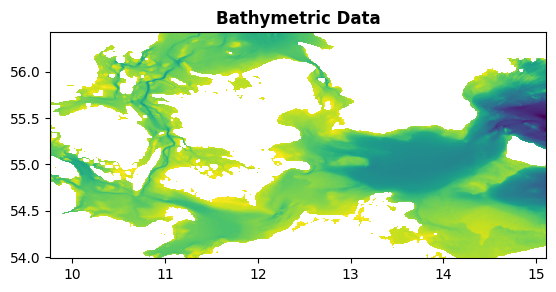


Water depth at point (10.0, 55.0): -11.0 meters

Minimum depth of polygon (13.0, 55.0) (14.0, 56.0): -48.0 meters
Maximum depth of polygon (13.0, 55.0) (14.0, 56.0): 0.0 meters
Mean depth of polygon (13.0, 55.0) (14.0, 56.0): -18.90334386957245 meters

Minimum depth along the route (13.0, 55.0) (14.0, 55.0): -47.0 meters
Maximum depth along the route (13.0, 55.0) (14.0, 55.0): 0.0 meters
Mean depth along the route (13.0, 55.0) (14.0, 55.0): -24.353658536585368 meters


In [33]:

class BathymetryAnalyzer:
    def __init__(self, bathymetry_file, tid_file):
        self.bathymetry_file = bathymetry_file
        self.tid_file = tid_file
        self.bathymetry_data = None
        self.tid_data = None
        self.metadata = None
        self.transform = None
        self.load_data()

    def load_data(self):
        with rasterio.open(self.bathymetry_file) as bathy_src:
            self.bathymetry_data = bathy_src.read(1).astype(float)
            self.metadata = bathy_src.meta
            self.transform = bathy_src.transform

        with rasterio.open(self.tid_file) as tid_src:
            self.tid_data = tid_src.read(1)
            # 将陆地区域的值设为 NaN
            self.bathymetry_data[self.tid_data == 0] = np.nan

    def get_depth_at_coordinates(self, lon, lat, target_crs=None):
        if target_crs:
            lon, lat = self._transform_coordinates(lon, lat, target_crs)

        # 将经纬度坐标转换为栅格坐标
        row, col  = rasterio.transform.rowcol(self.transform, lon, lat)

        # 检查坐标是否在数据范围内
        if not (0 <= row < self.metadata['height'] and 0 <= col < self.metadata['width']):
            raise ValueError("The provided coordinates are outside the bathymetry data range.")

        # 获取对应栅格的水深
        depth = self.bathymetry_data[row, col]

        return depth

    def get_depth_between_coordinates(self, lon1, lat1, lon2, lat2, target_crs=None):
        if target_crs:
            lon1, lat1 = self._transform_coordinates(lon1, lat1, target_crs)
            lon2, lat2 = self._transform_coordinates(lon2, lat2, target_crs)

        # 将两个点的经纬度坐标转换为栅格坐标
        row1, col1 = rasterio.transform.rowcol(self.transform, lon1, lat1)
        row2, col2 = rasterio.transform.rowcol(self.transform, lon2, lat2)
        
        # 检查坐标是否在数据范围内
        if not (0 <= row1 < self.metadata['height'] and 0 <= row2 < self.metadata['height'] and
                0 <= col1 < self.metadata['width'] and 0 <= col2 < self.metadata['width']):
            raise ValueError("The provided coordinates are outside the bathymetry data range.")

        # 提取两个点之间的矩形区域
        subset_data = self.bathymetry_data[min(row1, row2):max(row1, row2)+1, min(col1, col2):max(col1, col2)+1]

        # 计算矩形区域内水深的最小值、最大值和平均值，忽略 NaN 值
        min_depth = np.nanmin(subset_data)
        max_depth = np.nanmax(subset_data)
        mean_depth = np.nanmean(subset_data)

        return min_depth, max_depth, mean_depth

    def get_depth_along_route(self, lon1, lat1, lon2, lat2, num_points=100, target_crs=None):
        if target_crs:
            lon1, lat1 = self._transform_coordinates(lon1, lat1, target_crs)
            lon2, lat2 = self._transform_coordinates(lon2, lat2, target_crs)

        # 计算航路上的点
        route_lats = np.linspace(lat1, lat2, num_points)
        route_lons = np.linspace(lon1, lon2, num_points)

        # 将航路上的点映射到栅格坐标
        route_rows, route_cols = rasterio.transform.rowcol(self.transform, route_lons, route_lats)

        # 提取航路上点周围的水深信息
        depths = [self.bathymetry_data[row, col] for row, col in zip(route_rows, route_cols)]

        # 计算航路上水深的最小值、最大值和平均值，忽略 NaN 值
        min_depth = np.nanmin(depths)
        max_depth = np.nanmax(depths)
        mean_depth = np.nanmean(depths)

        return min_depth, max_depth, mean_depth

    def visualize_bathymetry(self):
        # 使用rasterio.plot中的show函数来显示水深数据
        show(self.bathymetry_data, transform=self.transform, cmap='viridis', title='Bathymetric Data')
        plt.show()

    def _transform_coordinates(self, lon, lat, target_crs):
        # 将经纬度坐标转换为目标坐标系下的坐标
        lon, lat = rasterio.warp.transform(self.metadata['crs'], target_crs, [lon], [lat])
        return lon[0], lat[0]

# 示例用法
bathymetry_file = cfg.bathymetry_file
tid_file = cfg.tid_file
analyzer = BathymetryAnalyzer(bathymetry_file, tid_file)

# 可视化水深数据
analyzer.visualize_bathymetry()

# 例子1: 获取经纬度对应的水深
depth_at_point = analyzer.get_depth_at_coordinates(lon=11.1, lat=55.1, target_crs='EPSG:4326')
print(f"\nWater depth at point (10.0, 55.0): {depth_at_point} meters")

# 例子2: 获取两点之间水深的最小值、最大值和平均值
min_depth, max_depth, mean_depth = analyzer.get_depth_between_coordinates(lon1=11.0, lat1=55.0, lon2=14.0, lat2=56.0, target_crs='EPSG:4326')

print(f"\nMinimum depth of polygon (13.0, 55.0) (14.0, 56.0): {min_depth} meters")
print(f"Maximum depth of polygon (13.0, 55.0) (14.0, 56.0): {max_depth} meters")
print(f"Mean depth of polygon (13.0, 55.0) (14.0, 56.0): {mean_depth} meters")

min_depth, max_depth, mean_depth = analyzer.get_depth_along_route(lon1=11.0, lat1=55.0, lon2=14.0, lat2=55.0, num_points=100, target_crs='EPSG:4326')
print(f"\nMinimum depth along the route (13.0, 55.0) (14.0, 55.0): {min_depth} meters")
print(f"Maximum depth along the route (13.0, 55.0) (14.0, 55.0): {max_depth} meters")
print(f"Mean depth along the route (13.0, 55.0) (14.0, 55.0): {mean_depth} meters")
